# Computing descriptors and distortion scores

## Prerequisites

In [1]:
#If ase is not available:
# In Jupyter, a line starting with ! is executed as a bash command, not a Python instruction 
! pip install ase


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import ase, ase.build, ase.io
import numpy as np
import matplotlib 

In [3]:
# a LAMMPS executable built with the ML-SNAP package enabled is needed.
lammps_executable = 'mpirun -np 2 ./lmp'

**Note:** In my case I need to source /opt/intel/oneapi/setvars.sh that will load gcc and other intel env variables. If you don't need it, you don't need it (same for mpirun above..).

In [4]:
## To verify SNAP is available

# source script to load software dependencies if needed lile mpi or gcc
! source /opt/intel/oneapi/setvars.sh \
&& echo -e pair_style snap \\n quit | \
$lammps_executable && \
echo "=== SNAP package available ==="

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.4(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
LAMMPS (29 Aug 2024 - Update 1)
=== SNAP package available ===


# Create atoms and compute descriptors

In [5]:
# Create bcc structure replicated 4 times in x, y and z.

bcc_Fe = ase.build.bulk("Fe", 
                        crystalstructure="bcc", 
                        cubic=True) * [4, 4, 4]

# show created ase.Atoms object
print(bcc_Fe)

# save to disk in lammps-readable format
ase.io.write("data/Fe_128.lammps-data", bcc_Fe, format="lammps-data")

Atoms(symbols='Fe128', pbc=True, cell=[11.48, 11.48, 11.48])


Save a LAMMPS script to disk so we can call it to compute descriptors. It has two variables `${input}` and `${output}` that we will set from command line

**Note 1** Bispectrum settings are indicative and should be tested on your system (see docs).

**Note 2** A reduced descriptor (component-wise sum) is computed for the cell, following TD Swinburne, PRL (2023.


In [6]:
%%writefile compute_desc.lammps

units metal
atom_style atomic
boundary p p p
read_data ${input}

# Define a dummy pair style as no force field is needed
pair_style zero 8.0
pair_coeff * *
mass 1 1

# compute sna_atom all sna/atom rcut 6.0 with 2*jmax 8
compute         sna_atom all sna/atom 5.0 0.99363 8 0.5 1.0 rmin0 0.0

dump 1 all custom 1 ${output} id type xs ys zs c_sna_atom[*]
dump_modify 1 sort id

compute         global_bs all reduce sum c_sna_atom[*]

thermo_style            custom step c_global_bs[*]
thermo_modify line yaml format none

run 0

print "SNAP atomic descriptors (bispectrum) computed and dumped to sna_descriptors.dat"


Overwriting compute_desc.lammps


#  Running LAMMPS and reading outputs

In [7]:
! source /opt/intel/oneapi/setvars.sh && ./lmp -in compute_desc.lammps \
    -var input data/Fe_128.lammps-data -var output sna_descriptors.dat

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.4(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (11.48 11.48 11.48)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  128 atoms
  read_data CPU = 0.000 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- Type Label Framework: https://doi.org/10.1021/acs.jpcb.3c08419
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Generated 0 of 0 mixed pair

In [8]:
def read_desc(file):
    atoms_with_desc = ase.io.read(file)
    
    descriptors_matrix = np.zeros((len(atoms_with_desc), 55))
    for i in range(1, 56):
        descriptors_matrix[:, i-1] = atoms_with_desc.arrays[f"c_sna_atom[{i}]"].T
    
    return descriptors_matrix

Let's plot the per-atom bispectrum components. 

In [9]:
import matplotlib.pyplot as plt

def plot_desc(file):
    descriptors_abs = np.abs(read_desc(file))

    plt.plot(descriptors_abs);

Below, we see all components have the same values (one line = one component of the bispectrum. It is the same value over the different atoms as they are all equivalent).

Text(0.5, 0, 'atom id')

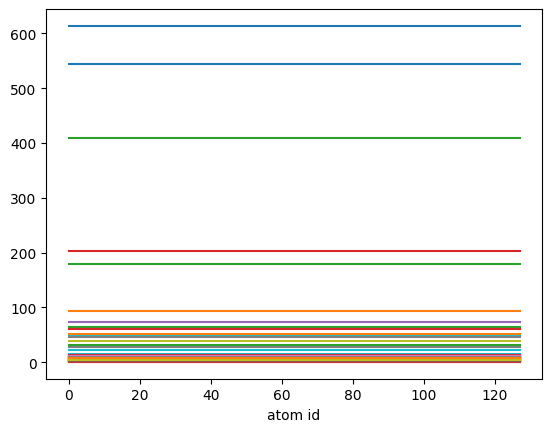

In [10]:
plot_desc("sna_descriptors.dat")
plt.xlabel("atom id")

To demonstrate how the global descriptor can be loaded (I won't use it here) (see TD Swinburne, PRL, 2023)


In [11]:
# load global descriptor
def parse_loglammps_yaml(file: str) -> list:
    """
    Parses thermo data from a LAMMPS log file formatted with YAML output.

    This function is specifically designed to handle log files generated when the
    `thermo_modify line yaml format none` keyword is used in LAMMPS.
    
    This Python code snippet was taken from LAMMPS documentation.

    Args:
        file (str): The path to the LAMMPS log file with YAML formatted thermo data.

    Returns:
        list: A list of dictionaries, where each dictionary represents a single
              thermo data block from the log file. The structure of the dictionaries
              depends on the specific LAMMPS settings used during the simulation.
    """

    import re, yaml
    try:
        from yaml import CSafeLoader as Loader
    except ImportError:
        from yaml import SafeLoader as Loader

    docs = ""
    with open(file, "r") as f:
        for line in f:
            m = re.search(r"^(keywords:.*$|data:$|---$|\.\.\.$|  - \[.*\]$)", line)
            if m: docs += m.group(0) + '\n'

    thermo = list(yaml.load_all(docs, Loader=Loader))
    return thermo
    
global_descriptor = parse_loglammps_yaml("log.lammps")
global_descriptor

[{'keywords': ['Step',
   'c_global_bs[1]',
   'c_global_bs[2]',
   'c_global_bs[3]',
   'c_global_bs[4]',
   'c_global_bs[5]',
   'c_global_bs[6]',
   'c_global_bs[7]',
   'c_global_bs[8]',
   'c_global_bs[9]',
   'c_global_bs[10]',
   'c_global_bs[11]',
   'c_global_bs[12]',
   'c_global_bs[13]',
   'c_global_bs[14]',
   'c_global_bs[15]',
   'c_global_bs[16]',
   'c_global_bs[17]',
   'c_global_bs[18]',
   'c_global_bs[19]',
   'c_global_bs[20]',
   'c_global_bs[21]',
   'c_global_bs[22]',
   'c_global_bs[23]',
   'c_global_bs[24]',
   'c_global_bs[25]',
   'c_global_bs[26]',
   'c_global_bs[27]',
   'c_global_bs[28]',
   'c_global_bs[29]',
   'c_global_bs[30]',
   'c_global_bs[31]',
   'c_global_bs[32]',
   'c_global_bs[33]',
   'c_global_bs[34]',
   'c_global_bs[35]',
   'c_global_bs[36]',
   'c_global_bs[37]',
   'c_global_bs[38]',
   'c_global_bs[39]',
   'c_global_bs[40]',
   'c_global_bs[41]',
   'c_global_bs[42]',
   'c_global_bs[43]',
   'c_global_bs[44]',
   'c_global_bs[45

This is it, now you know how to compute bispectrums and load them into Python

# Repeat, now with random displacements

So far, all atoms were equivalent. Let's spice things a little bit and add some random displacements using the `Atoms.rattle()` method. Don't forget to work on a `.copy()` of perfect structures to keep them unchanged.

In [12]:
RATTLE_AMPLITUDE = 0.02
# add noise
atoms_with_desc_rattled = ase.io.read("data/Fe_128.lammps-data", style="atomic").copy() 
atoms_with_desc_rattled.rattle(RATTLE_AMPLITUDE)

# save
ase.io.write("data/Fe_128_rattled.lammps-data", atoms_with_desc_rattled)

In [13]:
! source /opt/intel/oneapi/setvars.sh && ./lmp -in compute_desc.lammps \
    -var input data/Fe_128_rattled.lammps-data \
    -var output sna_descriptors_rattled.dat

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.4(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (11.48 11.48 11.48)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  128 atoms
  read_data CPU = 0.000 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- Type Label Framework: https://doi.org/10.1021/acs.jpcb.3c08419
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Generated 0 of 0 mixed pair

Let's visualize the descriptor components. This time, they are different for each atom, but we can see very well here how a global descriptor would "average out" these variations.

Text(0.5, 0, 'Atom id')

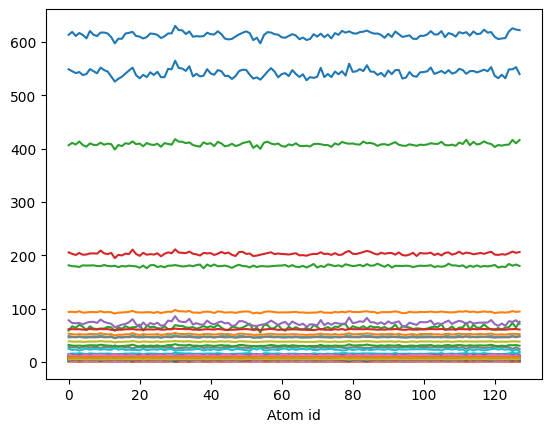

In [14]:
plot_desc("sna_descriptors_rattled.dat")
plt.xlabel("Atom id")

For (even) more fun, **let's also do another structure, an fcc**.

In [15]:
fcc_Fe = ase.build.bulk("Fe", 
                        crystalstructure="fcc", 
                        a=3.57,
                        cubic=True) * [4, 4, 4]
ase.io.write("data/fcc_128.lammps-data", fcc_Fe)

fcc_Fe_rattled = fcc_Fe.copy()
fcc_Fe_rattled.rattle(RATTLE_AMPLITUDE)
ase.io.write("data/fcc_128_rattled.lammps-data", fcc_Fe_rattled)


Compute descriptors by calling LAMMPS...

In [16]:
! source /opt/intel/oneapi/setvars.sh && ./lmp -in compute_desc.lammps \
    -var input data/fcc_128.lammps-data \
    -var output sna_descriptors_fcc.dat

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.4(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (14.28 14.28 14.28)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  256 atoms
  read_data CPU = 0.001 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- Type Label Framework: https://doi.org/10.1021/acs.jpcb.3c08419
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Generated 0 of 0 mixed pair

In [17]:
! source /opt/intel/oneapi/setvars.sh && ./lmp -in compute_desc.lammps \
    -var input data/fcc_128_rattled.lammps-data \
    -var output sna_descriptors_fcc_rattled.dat


 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.4(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (14.28 14.28 14.28)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  256 atoms
  read_data CPU = 0.001 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- Type Label Framework: https://doi.org/10.1021/acs.jpcb.3c08419
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Generated 0 of 0 mixed pair

### Visualize results

Here we'll just project bispectrum components on the 2D plane using the PCA methods that allows to find the orthogonal vectors that explain most of the variance in the data. 

Remember that this is a projection, which can cause visualization artifacts. 

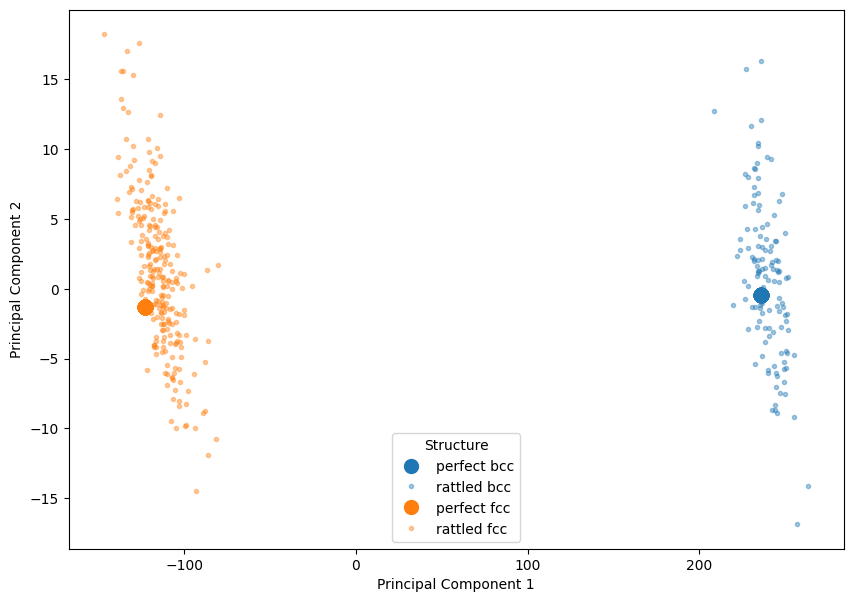

In [18]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=2)

descriptors = {"bcc":
               {"perfect": read_desc("sna_descriptors.dat"),
               "rattled": read_desc("sna_descriptors_rattled.dat")},
              "fcc":
               {"perfect": read_desc("sna_descriptors_fcc.dat"),
               "rattled": read_desc("sna_descriptors_fcc_rattled.dat")}
              }


# Concatenate all descriptors for PCA fitting
all_descriptors = []
for crystal_type in descriptors:
    for state in descriptors[crystal_type]:
        all_descriptors.append(descriptors[crystal_type][state])
X = np.concatenate(all_descriptors)

pca.fit(X)

# Define plot styles for clarity
plot_styles = {
    "perfect": {"marker": "o", "markersize": 10, "alpha": 1},
    "rattled": {"marker": ".", "markersize": 6, "alpha": 0.4} # Adjusted alpha for rattled for better visibility
}

colors = ["C0", "C1"] # Assign different colors for bcc and fcc

# Plotting
plt.figure(figsize=(10, 7)) # Make the plot a bit larger

for i, (crystal_type, states) in enumerate(descriptors.items()):
    for state_name, desc_data in states.items():
        Y = pca.transform(desc_data)
        plt.plot(
            Y[:, 0],
            Y[:, 1],
            plot_styles[state_name]["marker"],
            color=colors[i],
            markersize=plot_styles[state_name]["markersize"],
            alpha=plot_styles[state_name]["alpha"],
            label=f"{state_name} {crystal_type}"
        )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Structure")
plt.show()

A more rigorous way to compare points is to use the statistical Mahalanobis distance, which can operate in high dimension (before projection) and which is robust against non-isotropic distributions (non trivial covariance matrix). It is very easy to compute based on sklearn. 

Note how the color of the points doesn't match their distance to the distribution center on the 2D projection, indicating a visualization artifact.

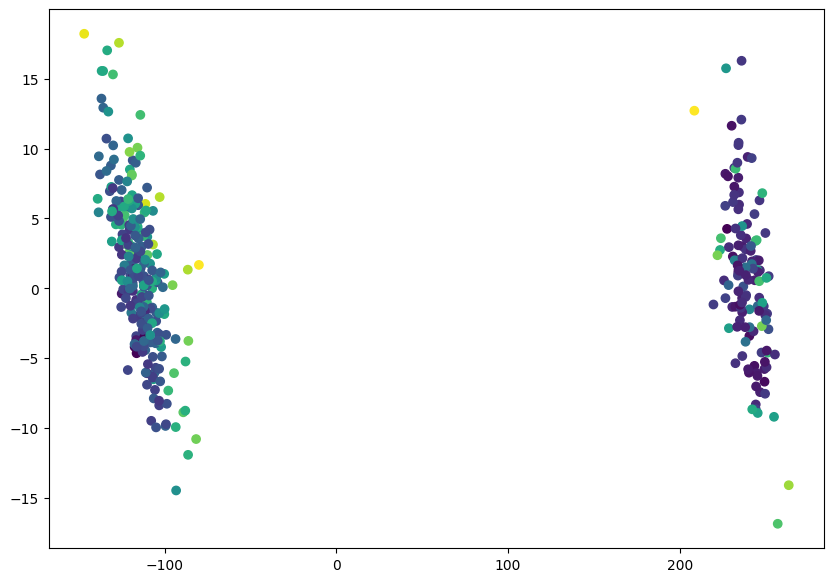

In [19]:
import sklearn.covariance 

plt.figure(figsize=(10, 7)) # Make the plot a bit larger

for i, (crystal_type, _) in enumerate(descriptors.items()):
    
    cov = sklearn.covariance.EllipticEnvelope(random_state=1).fit(descriptors[crystal_type]["rattled"])
    distances = cov.mahalanobis(descriptors[crystal_type]["rattled"])

    pca = sklearn.decomposition.PCA(n_components=2).fit(X)
    Y = pca.transform(descriptors[crystal_type]["rattled"])
    plt.scatter(
        Y[:, 0],
        Y[:, 1],
        marker="o",
        c=distances,
        cmap="viridis",
        norm=matplotlib.colors.LogNorm()
    )

In the absence of an obvious ground truth, we could obrain the same result using a n-class Gaussian Mixture Model that allows us to estimate the probability over the dataset, by discovering Gaussians. The mahalanobis distance can then be computed using the `gmm.means_` and `gmm.precisions_` (inverse of cov matrix)

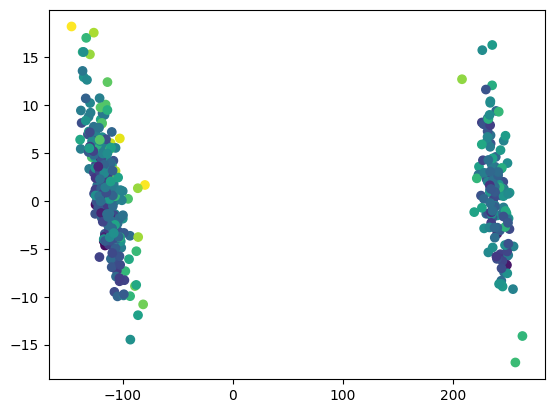

In [20]:
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis

rattled_descriptors = np.concatenate([descriptors[crystal_type]["rattled"] for crystal_type in ["fcc", "bcc"]])
gmm = GaussianMixture(n_components=2, n_init=20)
gmm.fit(rattled_descriptors)


distances = []
for sample in rattled_descriptors:
    distances.append([mahalanobis(sample, gmm.means_[i], gmm.precisions_[i]) for i in range(2)])

plt.scatter(
    pca.transform(rattled_descriptors)[:,0],
    pca.transform(rattled_descriptors)[:,1],
    c=np.min(distances, axis=1),
    cmap="viridis",
    # norm=matplotlib.colors.LogNorm()

)

## Save statistical distance to extxyz format for visualization in ovito

In [21]:
import ase.io.extxyz

for s in ["bcc", "fcc"]:
    cov = sklearn.covariance.EllipticEnvelope(random_state=1).fit(descriptors[s]["rattled"])
    distances = cov.mahalanobis(descriptors["bcc"]["rattled"])

    atoms_with_desc_rattled.set_array(f"maha_{s}", distances)
    
atoms_with_desc_rattled.set_chemical_symbols(["Fe"]*len(atoms_with_desc_rattled))

ase.io.extxyz.write_extxyz("data/labelled_bcc_Fe.extxyz", atoms_with_desc_rattled, columns=["symbols", "positions", "id",   "maha_bcc", "maha_fcc"])

In [22]:
cat data/labelled_bcc_Fe.extxyz

128
Lattice="11.48 0.0 0.0 0.0 11.48 0.0 0.0 0.0 11.48" Properties=species:S:1:pos:R:3:id:I:1:maha_bcc:R:1:maha_fcc:R:1 comment="data/Fe_128.lammps-data (written by ASE)" pbc="T T T"
Fe       0.00993428      -0.00276529       0.01295377        1      60.55092821 25797670.79464890
Fe       1.46546060       1.43031693       1.43031726        2      55.96033241 24568430.62043459
Fe       0.03158426       0.01534869       2.86061051        3     207.24601635 26353440.68719966
Fe       1.44585120       1.42573165       4.29568540        4      58.34897370 26930599.50230289
Fe       0.00483925      -0.03826560       5.70550164        5      70.86158754 24787857.18748730
Fe       1.42375425       1.41474338       7.18128495        6      53.75366724 26071517.03094243
Fe      -0.01816048      -0.02824607       8.63931298        7      65.47388528 24687657.42120479
Fe       1.43048447       1.43635056      10.01650504        8      49.62114300 26312636.61201212
Fe      -0.01088765       2.87221

Text(0.5, 1.0, 'bcc compared to bcc (blue) and fcc (orange)')

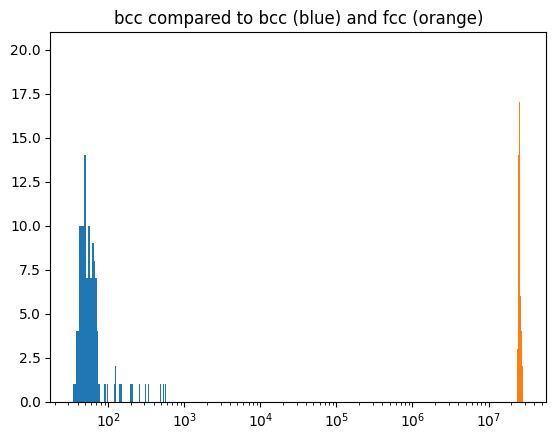

In [23]:
plt.hist(atoms_with_desc_rattled.arrays["maha_bcc"], bins=500)
plt.hist(atoms_with_desc_rattled.arrays["maha_fcc"], bins=20)
plt.xscale("log")
plt.title("bcc compared to bcc (blue) and fcc (orange)")